## Load Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import random
from tifffile import imsave
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

from rasterio import features
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature


## Open and Inspect Data

In [2]:
# Access data files
dfs = xr.open_mfdataset('/media/silsbelab/gommab/mab/cci/chl/chl*.nc', engine='netcdf4', combine='by_coords') #, chunks={'time': 8024, 'lat': 156, 'lon': 168}

print(dfs)

<xarray.Dataset>
Dimensions:  (lat: 156, lon: 168, time: 8024)
Coordinates:
  * lat      (lat) float32 41.479168 41.4375 41.395832 ... 35.0625 35.020832
  * lon      (lon) float32 -76.979164 -76.9375 ... -70.0625 -70.020836
  * time     (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2019-12-31
Data variables:
    chlor_a  (time, lat, lon) float32 dask.array<chunksize=(31, 156, 168), meta=np.ndarray>
Attributes:
    Conventions:                    CF-1.7
    start_date:                     30-DEC-2019 00:00:00.000000
    stop_date:                      30-DEC-2019 23:59:00.000000
    Metadata_Conventions:           Unidata Dataset Discovery v1.0
    cdm_data_type:                  Grid
    comment:                        See summary attribute
    creation_date:                  20200121T164055Z
    creator_email:                  help@esa-oceancolour-cci.org
    creator_name:                   Plymouth Marine Laboratory
    creator_url:                    http://esa-oceancolour-cci.org

## Mask Bathymetry

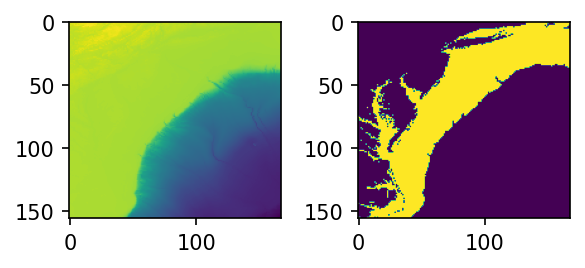

In [3]:
# Bathytmetry data regridded to CCI data (had to this in R)
import numpy as np

f = netCDF4.Dataset('/media/silsbelab/gommab/mab/bathymetry/gebco_2020_cci_res.nc', "r+", format="NETCDF4")

# Read in Variables and Convert to Numpy Arrays using [:]
dem = f.variables['gebco_2020_n41.5_s35.0_w.77.0_e.70.0'][:] 

fig = plt.figure(figsize=(4, 4), dpi=150)

plt.subplot(1, 2, 1)
plt.imshow(dem)

# Note that the file has both bathymetry (negative values) and land elevation (positive Values)
# Mask sets any depth between 0-200 m as 1, all other set to 0
dem = np.where((dem < 0) & (dem > (-200)), 1, 0)

plt.subplot(1, 2, 2)
plt.imshow(dem)
fig.tight_layout()

dem = dem.flatten()


# Data Wrangling

In [4]:
# Reduce Temporal Resolution by taking mean of month
da = dfs.resample(time="M").mean()

# Convert time dimension separate month and year dimensions
x = [1,2,3,4,5,6,7,8,9,10,11,12]
y = [1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
ind = pd.MultiIndex.from_product((x,y),names=('month','year'))

# Write this new dimension back into xarray.Dataset
da = da.assign(time=ind).unstack('time')

da = da.mean(dim=('year'))

# Unstack Dataset and convert to array
da2 = da.stack(gridcell=["lat", "lon"]).to_array()


# to_array adds a non-sense dimension 'variable' and transposes it. Get rid of extra dimension and retranspose
# probably a better way to do this
da2 = da2.squeeze('variable').transpose()

print(da2.shape)

(26208, 12)


## Data Wrangling 2: Convert xarray to numpy and prep for machine learning

In [5]:
# Convert stack xarray to numpy array
arr = np.array(da2)

print(arr.shape)

# Get index in arr where dem is not masked and each month has data
ind = np.argwhere((dem>0) & (np.isfinite(arr.sum(axis=1)))).flatten()

print(ind.shape)

# Keep only this data
arr = arr[ind]

print(arr.shape)

# Normalize Data (mean = 1)
arr = arr/arr.mean(axis=1, keepdims=True)

print(arr.shape)


/home/silsbelab/anaconda2/envs/mab/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(26208, 12)
(7509,)
(7509, 12)
(7509, 12)


## Apply kmeans spectral classification
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

In [6]:
kmeans = KMeans(n_clusters=8, init='k-means++', max_iter=3000, n_init=100, random_state=100)
pred_y = kmeans.fit_predict(arr)

## Retrieve and reassemble data

In [35]:
# Phenological Classification Maps
phenology = np.empty(26208)
phenology[:] = np.nan
np.put(phenology, ind, pred_y)

# Convert back to xarray 
phenx = xr.DataArray(phenology, coords=[da2.coords['gridcell']], name='cluster')
phenx = phenx.unstack()
print(phenx)

# Save as netcdf
phenx.to_netcdf(path='/media/silsbelab/gommab/mab/cci/analysis/phenology climatology.nc')

# Phenology Clusters
clusters = kmeans.cluster_centers_
np.savetxt('/media/silsbelab/gommab/mab/cci/analysis/kmeans_clusters climatology.txt', clusters, delimiter='\t')


<xarray.DataArray 'cluster' (lat: 156, lon: 168)>
array([[nan, nan, nan, ...,  8.,  8.,  8.],
       [nan, nan, nan, ...,  8.,  8.,  8.],
       [nan, nan, nan, ...,  8.,  8.,  8.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 41.48 41.44 41.4 41.35 ... 35.15 35.1 35.06 35.02
  * lon      (lon) float64 -76.98 -76.94 -76.9 -76.85 ... -70.1 -70.06 -70.02


## Plots by Class

In [36]:
from pylab import *

cmap = cm.get_cmap('Set3', 12) #Set3 twilight
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    print(matplotlib.colors.rgb2hex(rgb))
    
# reorder
mycol = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#d9d9d9', '#fccde5','#bc80bd','#ccebc5','#ffed6f']

print(mycol)


#8dd3c7
#ffffb3
#bebada
#fb8072
#80b1d3
#fdb462
#b3de69
#fccde5
#d9d9d9
#bc80bd
#ccebc5
#ffed6f
['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#d9d9d9', '#fccde5', '#bc80bd', '#ccebc5', '#ffed6f']


In [6]:

da = xr.open_dataset('/media/silsbelab/gommab/mab/cci/analysis/phenology climatology.nc')

print(clusters.shape)
print(x)
da.cluster.plot()
plot(x, clusters)

NameError: name 'clusters' is not defined

In [10]:
## Plot By Year

<Figure size 3750x2250 with 0 Axes>

<Figure size 432x288 with 0 Axes>

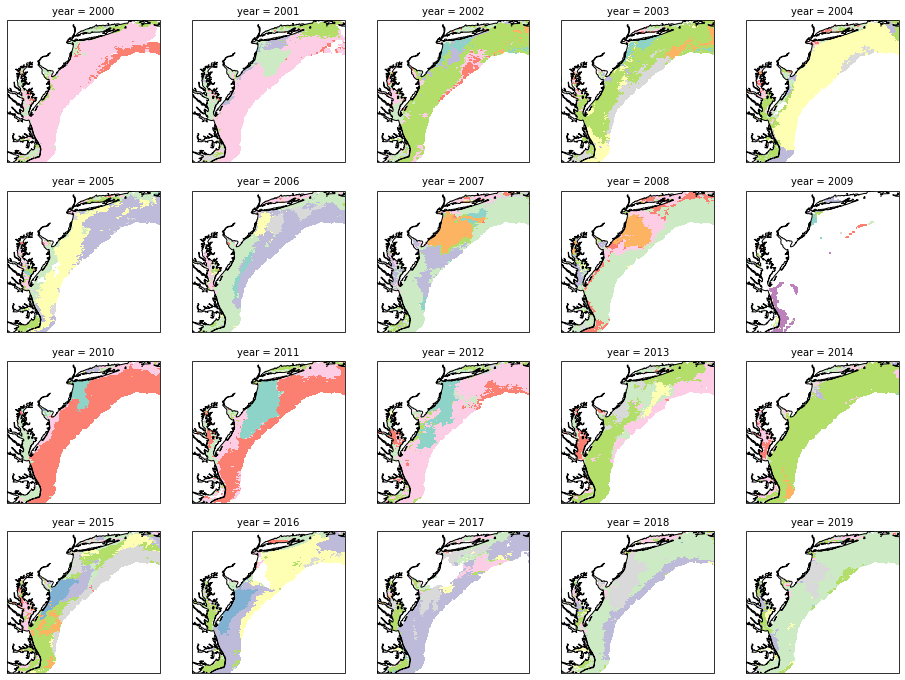

In [11]:

fig1 = plt.figure(figsize=(25, 15), dpi=150)
plt.figure()

p = phenx.sel(year=range(2000, 2020, 1)).plot(transform=ccrs.PlateCarree(),  
             col='year', col_wrap=5,  # multiplot settings
             subplot_kws={'projection': ccrs.PlateCarree()},
             colors = mycol,
             levels=12,
             add_colorbar=False)  # the plot's projection

# We have to set the map's options on all axes
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent([-77, -70, 35, 41.5])

plt.savefig('/media/gsilsbe/gommab/mab/cci/analysis/cluster maps/all.png', dpi=150, format="png", bbox_inches='tight')


/home/gsilsbe/.conda/envs/mab/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 750x375 with 0 Axes>

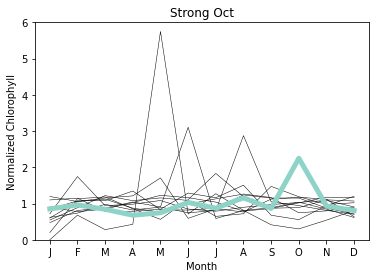

<Figure size 750x375 with 0 Axes>

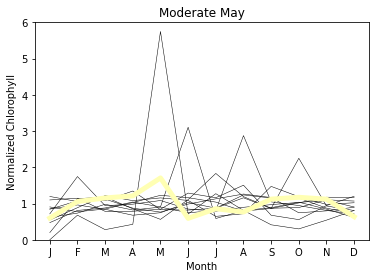

<Figure size 750x375 with 0 Axes>

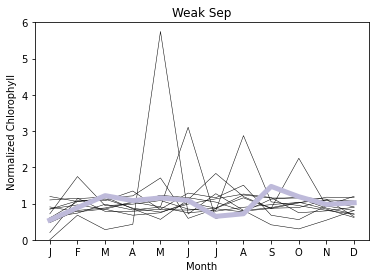

<Figure size 750x375 with 0 Axes>

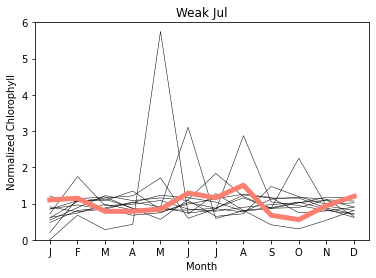

<Figure size 750x375 with 0 Axes>

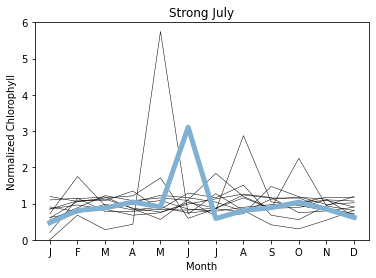

<Figure size 750x375 with 0 Axes>

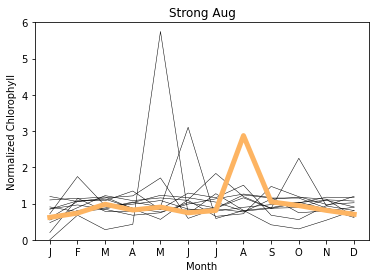

<Figure size 750x375 with 0 Axes>

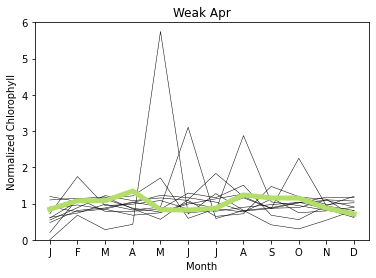

<Figure size 750x375 with 0 Axes>

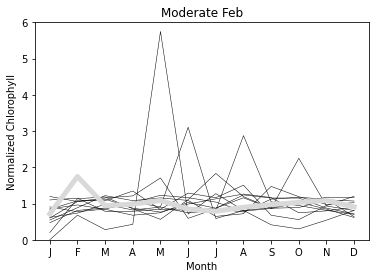

<Figure size 750x375 with 0 Axes>

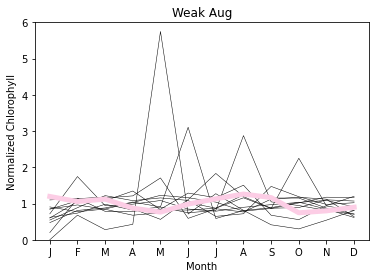

<Figure size 750x375 with 0 Axes>

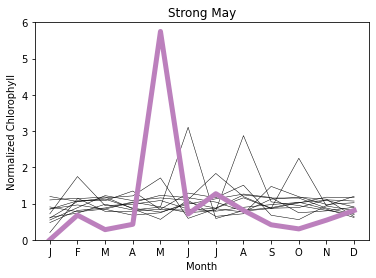

<Figure size 750x375 with 0 Axes>

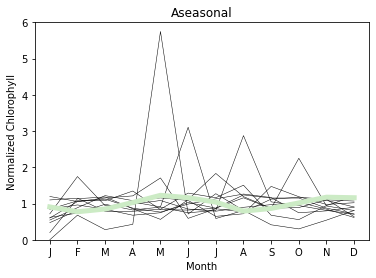

<Figure size 750x375 with 0 Axes>

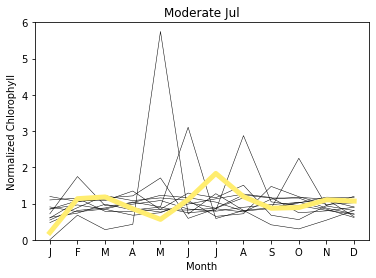

In [12]:
for i, lab in zip(range(0,12,1), mylab):
    
    fig1 = plt.figure(figsize=(5, 2.5), dpi=150)
    plt.figure()
    plt.ylim([0,6])
    plt.plot(clusters.transpose(), color='black', linewidth=0.5) 
    plt.plot(clusters[i,], color=mycol[i], linewidth=5) 
    plt.title(mylab[i])
    plt.xticks(np.arange(12), ['J','F','M','A','M','J','J','A','S','O','N','D']) 
    plt.xlabel("Month")
    plt.ylabel("Normalized Chlorophyll")

    plt.savefig('/media/gsilsbe/gommab/mab/cci/analysis/cluster maps/' + lab + ' phenology.png', dpi=150, format="png", bbox_inches='tight')

    

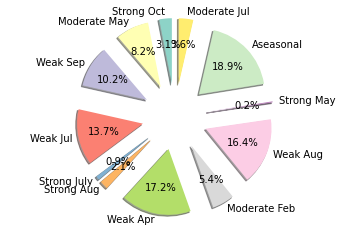

<Figure size 750x375 with 0 Axes>

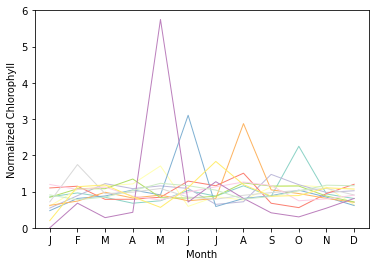

In [13]:
occurence = [0 for x in range(0,12)] 
for i in range(0,12):
    occurence[i] = xr.where(phenx == i, 1, np.nan).sum()


fig1, ax1 = plt.subplots()
ax1.pie(occurence, explode=np.repeat(0.5,12),labels=mylab, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = mycol, textprops={'fontsize': 10})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

fig1.savefig('/media/gsilsbe/gommab/mab/cci/analysis/cluster maps/pie chart.png')

fig1 = plt.figure(figsize=(5, 2.5), dpi=150)
plt.figure()

for i, lab in zip(range(0,12,1), mylab):
    plt.ylim([0,6])
    plt.plot(clusters[i,], color=mycol[i], linewidth=1) 
    plt.xticks(np.arange(12), ['J','F','M','A','M','J','J','A','S','O','N','D']) 
    plt.xlabel("Month")
    plt.ylabel("Normalized Chlorophyll")

plt.savefig('/media/gsilsbe/gommab/mab/cci/analysis/cluster maps/phenology.png', dpi=150, format="png", bbox_inches='tight')

# Plot a year

## Code to determine optimal number of clusters

In [6]:
from gap_statistic import OptimalK

optimalK = OptimalK(parallel_backend='rust')
optimalK

n_clusters = optimalK(arr, cluster_array=np.arange(5, 15))
print('Optimal clusters: ', n_clusters)

optimalK.gap_df

ModuleNotFoundError: No module named 'gap_statistic'